In [3]:
import sys
import os

# Add the parent directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

Opening and lazy loading netCDF files
Loading dataset into memory
Converting xarray Dataset to Pytorch tensor

##########################################
############ PROCESSING DONE #############
##########################################

Opening and lazy loading netCDF files
Loading dataset into memory
Converting xarray Dataset to Pytorch tensor

##########################################
############ PROCESSING DONE #############
##########################################

Opening and lazy loading netCDF files
Loading dataset into memory
Converting xarray Dataset to Pytorch tensor

##########################################
############ PROCESSING DONE #############
##########################################



Train :: Epoch: 1/2:   0%|                                                                                                                                        | 0/685 [00:00<?, ?it/s]

Computing statistics for standardization


:: Evaluation :::   1%|█▏                                                                                                                                 | 2/229 [00:00<00:12, 18.65it/s]

Computing statistics for standardization


:: Evaluation ::: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 229/229 [00:16<00:00, 13.63it/s]


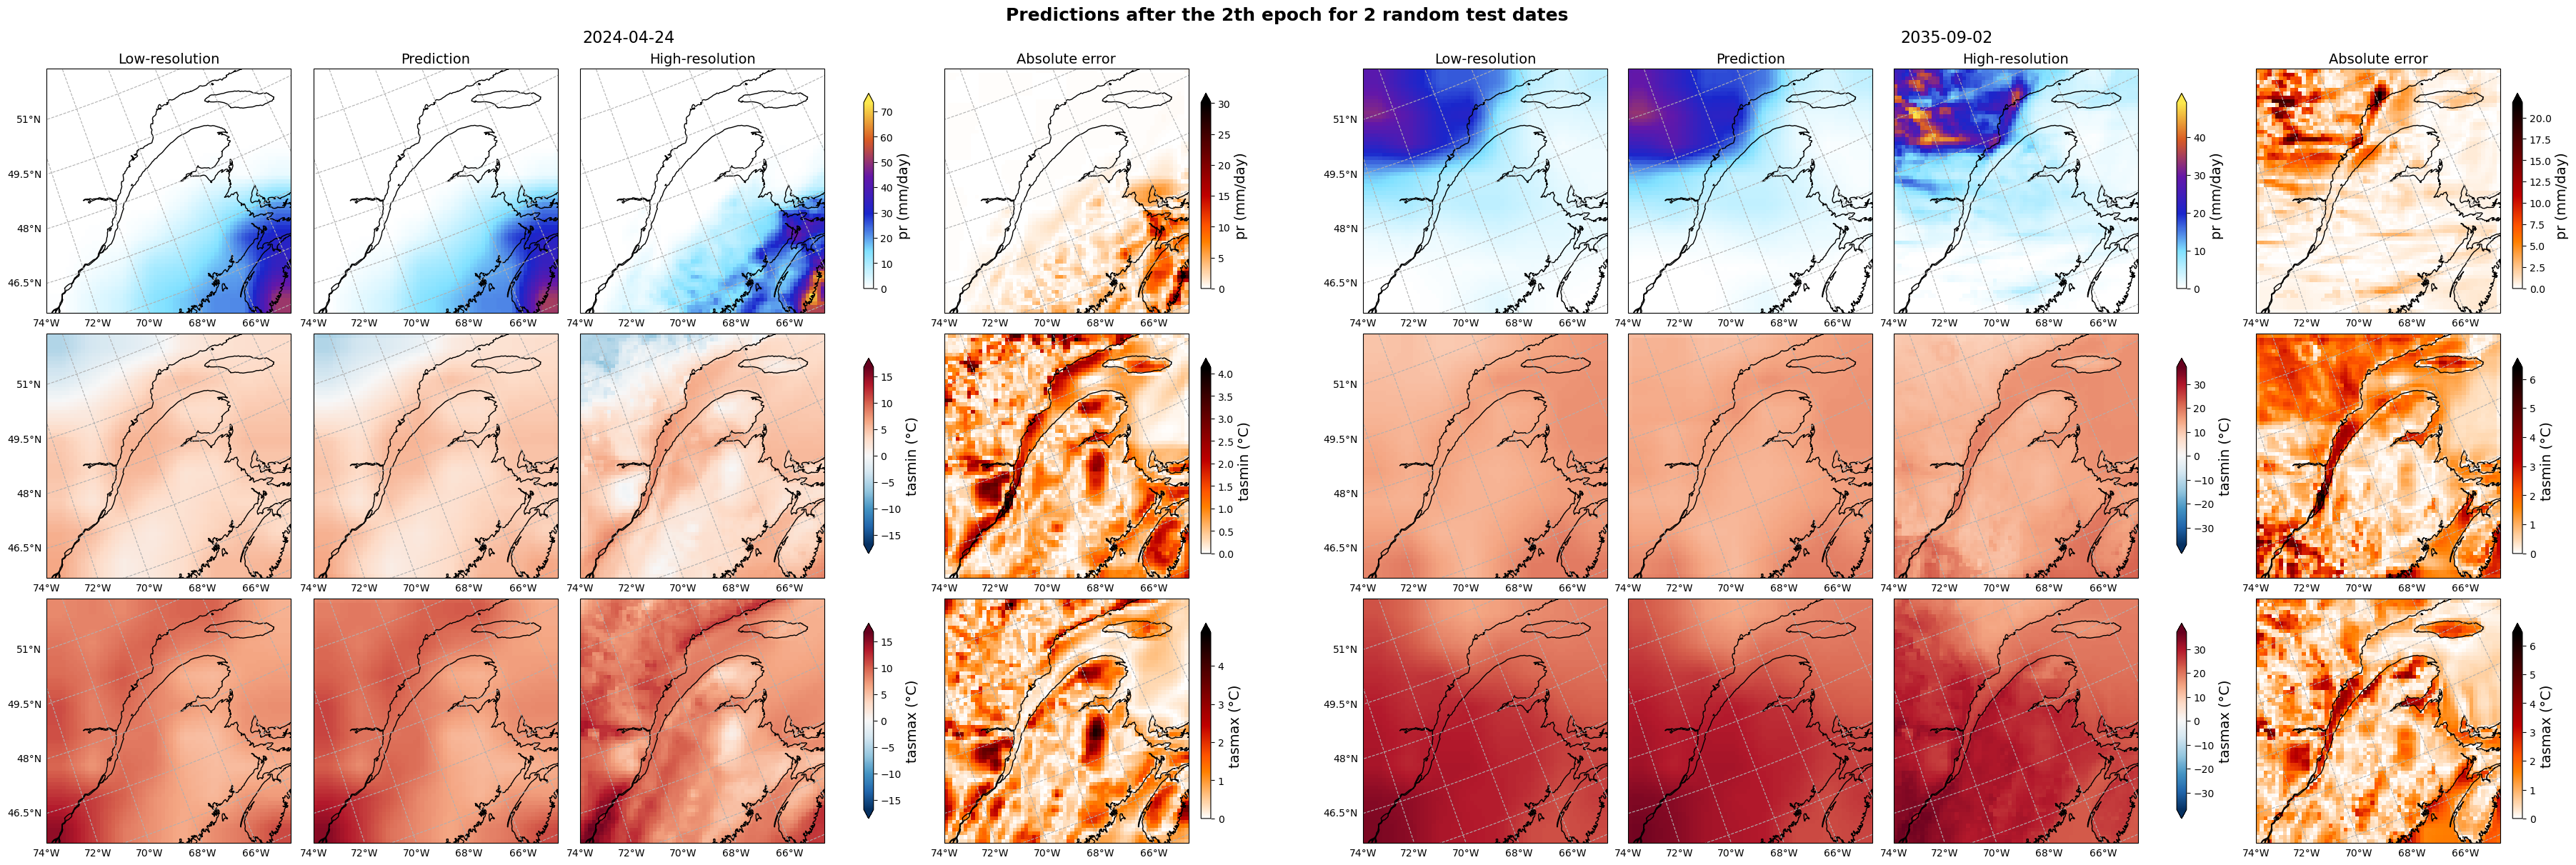

:: Evaluation ::: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 229/229 [00:16<00:00, 13.54it/s]

MAE for precipitation on validation data:  1.2205027573493892
MAE for tasmin on validation data:  1.3472698648423607
MAE for tasmax on validation data:  0.9938441796073747


In [1]:
import torch
import wandb
import numpy as np
import matplotlib.pyplot as plt

import climex_utils as cu
import trainmodel as tm
import baseline.models as mdls
import networks as det_unet

# For plotting the smoothed training and validation losses
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

# For reproducibility
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


if __name__ == "__main__":

    # Importing all required arguments
    args = tm.get_args()

    args.batch_size = 32
    args.num_epochs = 2

    
    seed_everything(42)

    # Initializing WandB
    if args.wandb:
        wandb.init(project="prob-unet-mds", config={"model": args.ds_model, "epochs": 1}, name=f"{args.resolution}_{args.ds_model}")

    # Initiliazing the training, validation and testing datasets
    dataset_train = cu.climex2torch(args.datadir, years=args.years_train, coords=args.coords, lowres_scale=args.lowres_scale, standardization="perpixel")
    dataset_val = cu.climex2torch(args.datadir, years=args.years_val, coords=args.coords, lowres_scale=args.lowres_scale, standardization="perpixel")
    dataset_test = cu.climex2torch(args.datadir, years=args.years_test, coords=args.coords, lowres_scale=args.lowres_scale)

    # Training chosen deep learning model or applying BCSD
    if args.ds_model == "bcsd":
        val_preds = mdls.BCSD(datatrain=dataset_train, datatest=dataset_val)
        test_preds = mdls.BCSD(datatrain=dataset_train, datatest=dataset_test)
    else:
        if args.ds_model == "deterministic_unet":
            model = det_unet.UNet(img_resolution=args.resolution, in_channels=len(args.variables), out_channels=len(args.variables), label_dim=0, use_diffuse=False)
        elif args.ds_model == "linearcnn":
            model = mdls.LinearCNN(resolution=args.resolution, in_channels=len(args.variables), ds_factor=args.lowres_scale)

        model.to(args.device)
        if args.wandb:
            wandb.watch(models=model)

        # Initiliazing the dataloaders
        dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=args.batch_size, shuffle=True)
        dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=args.batch_size, shuffle=False)
        dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=args.batch_size, shuffle=False)
        dataloader_val_random = torch.utils.data.DataLoader(dataset_val, batch_size=args.batch_size, shuffle=True)

        # Initiliazing training objects
        scaler = torch.cuda.amp.GradScaler()
        optimizer = args.optimizer(params=model.parameters(), lr=args.lr)
        loss_fn = torch.nn.MSELoss()

        # tr_losses = dict.fromkeys(args.variables, [])
        # val_losses = dict.fromkeys(args.variables, [])
        tr_losses = {var: [] for var in args.variables}
        val_losses = {var: [] for var in args.variables}
        # Looping over all epochs
        for epoch in range(1, args.num_epochs+1):

            # Training for one epoch (going over all training data)
            tr_running_losses = tm.train_step(model=model, dataloader=dataloader_train, loss_fn=loss_fn, optimizer=optimizer, scaler=scaler, epoch=epoch, num_epochs=args.num_epochs, accum=args.accum, act_wandb=args.wandb, device=args.device)
            
            # Evaluating the model on validation data
            val_running_losses = tm.eval_model(model=model, dataloader=dataloader_val, loss_fn=loss_fn, reconstruct=False, wandb=args.wandb, device=args.device)

            # Saving the training and validation losses
            for var in args.variables:
                tr_losses[var] = tr_losses[var] + tr_running_losses[var]
                val_losses[var] = val_losses[var] + val_running_losses[var]

        # Sampling and plotting the model's predictions
        hr_pred, (fig, axs) = tm.sample_model(model=model, dataloader=dataloader_val_random, epoch=args.num_epochs, device=args.device)
        fig.savefig(f"./{args.plotdir}/epoch{epoch}_samples_from_{args.ds_model}.png", dpi=300)
        plt.close(fig)

        # Plotting training and validation losses
        for var in args.variables:
            tr_loss = moving_average(np.array(tr_losses[var]), w=24)
            val_loss = moving_average(np.array(val_losses[var]), w=48)
            tr_x = np.arange(1, len(tr_loss)+1)
            val_x = np.linspace(1, len(tr_loss)+1, len(val_loss))
            fig = plt.figure(figsize=(15,10))
            plt.plot(tr_x, tr_loss, lw=2, label='training loss')
            plt.plot(val_x, val_loss, lw=2, linestyle='dashed', label='validation loss')
            plt.xlabel("Steps")
            plt.ylabel("MAE Loss")
            plt.title(f"MAE Loss for {var}")
            plt.legend()
            fig.savefig(f"./{args.plotdir}/loss_{var}.png", dpi=300)
            plt.close(fig)

        torch.save(model.state_dict(), f"./{args.checkpoints_dir}/{args.ds_model}.pt")
        torch.save(optimizer.state_dict(), f"./{args.checkpoints_dir}/{args.ds_model}_optimizer.pt")

        # Evaluating the model on the validation data
        mae_loss = tm.eval_model(model=model, dataloader=dataloader_val, loss_fn=torch.nn.L1Loss(), reconstruct=True, wandb=args.wandb, device=args.device)
        print("MAE for precipitation on validation data: ", np.mean(mae_loss["pr"][-len(dataloader_val):]))
        print("MAE for tasmin on validation data: ", np.mean(mae_loss["tasmin"][-len(dataloader_val):]))
        print("MAE for tasmax on validation data: ", np.mean(mae_loss["tasmax"][-len(dataloader_val):]))